In [85]:
from PIL import Image
from matplotlib.pyplot import imshow
import pandas
import matplotlib.pylab as plt
import os
import glob
import skillsnetwork

import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import skillsnetwork 

from torch.utils.data import DataLoader

import torch.nn as nn
import torch.optim as optim

In [86]:
def show_data(data_sample, shape = (28, 28)):
    plt.imshow(data_sample[0].numpy().reshape(shape), cmap='gray')
    plt.title('y = ' + data_sample[1])

In [87]:
await skillsnetwork.prepare("https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/concrete_crack_images_for_classification.zip", path = "resources/data", overwrite=True)

  0%|          | 0/40000 [00:00<?, ?it/s]

Saved to 'resources/data'


In [88]:
directory="resources/data/"
negative='Negative'


negative_file_path=os.path.join(directory,negative)
negative_file_path
os.listdir(negative_file_path)[0:3]
[os.path.join(negative_file_path,file) for file in  os.listdir(negative_file_path)][0:3]

print("test.jpg".endswith(".jpg"))
print("test.mpg".endswith(".jpg"))

negative_files=[os.path.join(negative_file_path,file) for file in  os.listdir(negative_file_path) if file.endswith(".jpg")]
negative_files.sort()
negative_files[0:3]

True
False


['resources/data/Negative/00001.jpg',
 'resources/data/Negative/00002.jpg',
 'resources/data/Negative/00003.jpg']

In [89]:
positive="Positive"

positive_file_path=os.path.join(directory,positive)
positive_files=[os.path.join(positive_file_path,file) for file in  os.listdir(positive_file_path) if file.endswith(".jpg")]
os.listdir(positive_file_path)[0:3]
[os.path.join(positive_file_path,file) for file in  os.listdir(positive_file_path)][0:3]

positive_files = [os.path.join(positive_file_path, file) for file in os.listdir(positive_file_path) if file.endswith(".jpg")]
positive_files.sort()
positive_files[0:3]

['resources/data/Positive/00001.jpg',
 'resources/data/Positive/00002.jpg',
 'resources/data/Positive/00003.jpg']

In [90]:
number_of_samples = len(positive_files) + len(negative_files)
number_of_samples

40000

In [91]:
Y=torch.zeros([number_of_samples])
Y=Y.type(torch.LongTensor)
Y.type()
Y[::2]=1
Y[1::2]=0

In [92]:
all_files = [None] * number_of_samples
all_files[::2] = positive_files
all_files[1::2] = negative_files

In [93]:
train=False

if train:
    all_files=all_files[0:30000]
    Y=Y[0:30000]

else:
    all_files=all_files[30000:]
    Y=Y[30000:]

In [98]:
class Dataset(Dataset):

    # Constructor
    def __init__(self,transform=None,train=True):
        directory="resources/data/"
        positive="Positive"
        negative="Negative"

        positive_file_path=os.path.join(directory,positive)
        negative_file_path=os.path.join(directory,negative)
        positive_files=[os.path.join(positive_file_path,file) for file in  os.listdir(positive_file_path) if file.endswith(".jpg")]
        positive_files.sort()
        negative_files=[os.path.join(negative_file_path,file) for file in  os.listdir(negative_file_path) if file.endswith(".jpg")]
        negative_files.sort()
        number_of_samples=len(positive_files)+len(negative_files)
        self.all_files=[None]*number_of_samples
        self.all_files[::2]=positive_files
        self.all_files[1::2]=negative_files 
        # The transform is goint to be used on image
        self.transform = transform
        #torch.LongTensor
        self.Y=torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2]=1
        self.Y[1::2]=0
        
        if train:
            self.all_files=self.all_files[0:30000] #Change to 30000 to use the full test dataset
            self.Y=self.Y[0:30000] #Change to 30000 to use the full test dataset
            self.len=len(self.all_files)
        else:
            self.all_files=self.all_files[30000:]
            self.Y=self.Y[30000:]
            self.len=len(self.all_files)    
       
    # Get the length
    def __len__(self):
        return self.len
    
    # Getter
    def __getitem__(self, idx):
        
        
        image=Image.open(self.all_files[idx])
        y=self.Y[idx]
          
        
        # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)

        return image, y

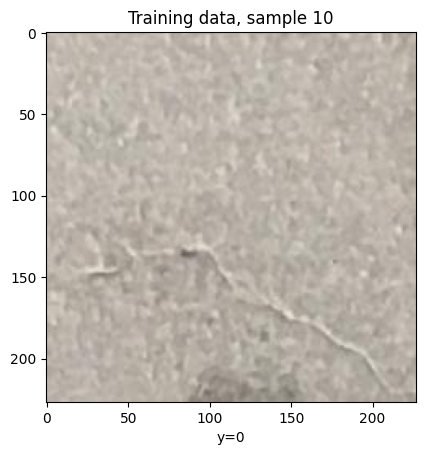

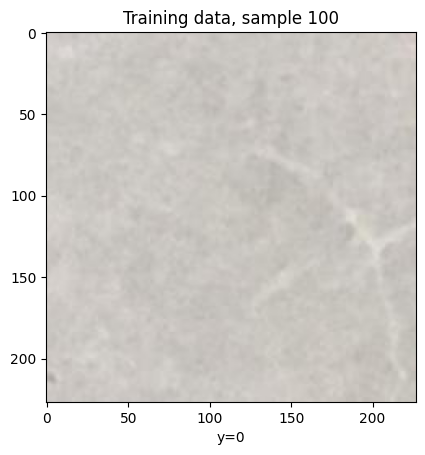

In [99]:
# Create the Dataset object for training data
dataset = Dataset(train=True)

# Print the 10th sample
sample_10 = dataset[9]
plt.imshow(sample_10[0])
plt.xlabel("y=" + str(sample_10[1].item()))
plt.title("Training data, sample 10")
plt.show()

# Print the 100th sample
sample_100 = dataset[99]
plt.imshow(sample_100[0])
plt.xlabel("y=" + str(sample_100[1].item()))
plt.title("Training data, sample 100")
plt.show()

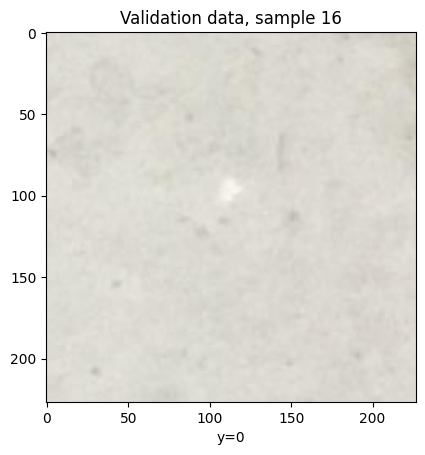

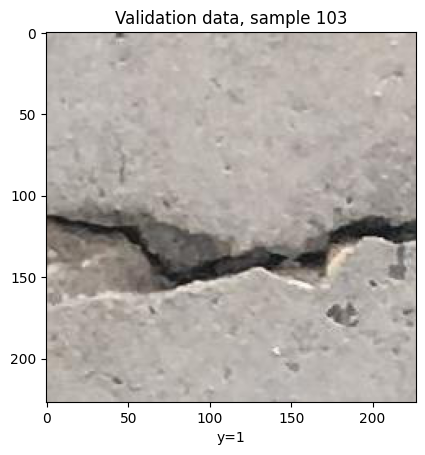

In [100]:
# Create the Dataset object for validation data
validation_dataset = Dataset(train=False)

# Print the 16th sample
sample_16 = validation_dataset[15]
plt.imshow(sample_16[0])
plt.xlabel("y=" + str(sample_16[1].item()))
plt.title("Validation data, sample 16")
plt.show()

# Print the 103rd sample
sample_103 = validation_dataset[102]
plt.imshow(sample_103[0])
plt.xlabel("y=" + str(sample_103[1].item()))
plt.title("Validation data, sample 103")
plt.show()

Training Dataset:


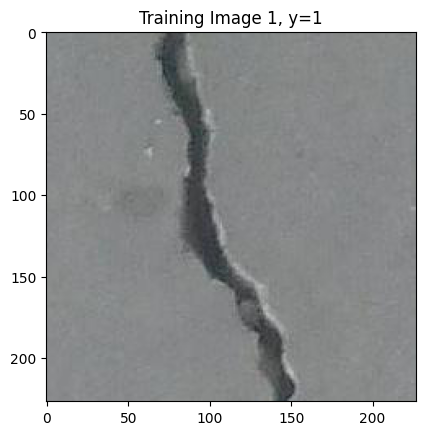

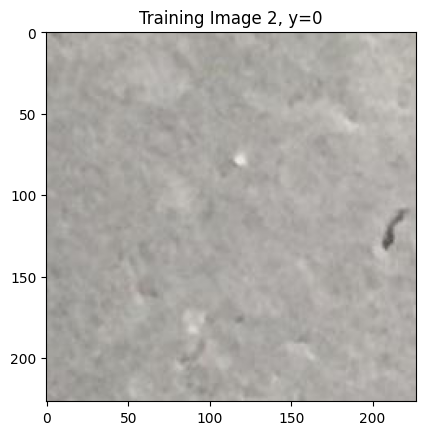

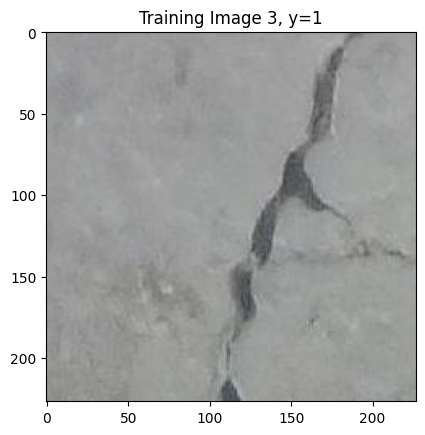

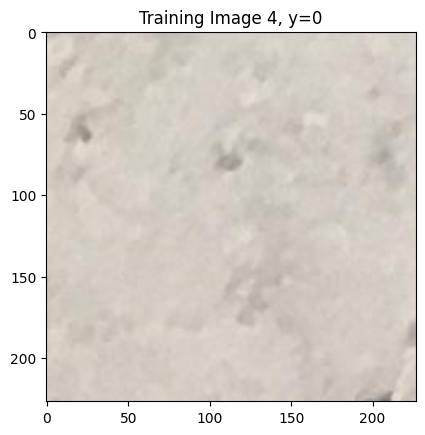

In [101]:
# Display the first four images from the training dataset
print("Training Dataset:")
for i in range(4):
    image, label = dataset[i]
    plt.imshow(image)
    plt.title(f"Training Image {i+1}, y={label.item()}")
    plt.show()

Validation Dataset:


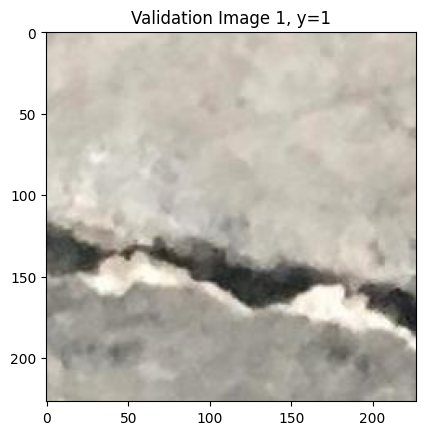

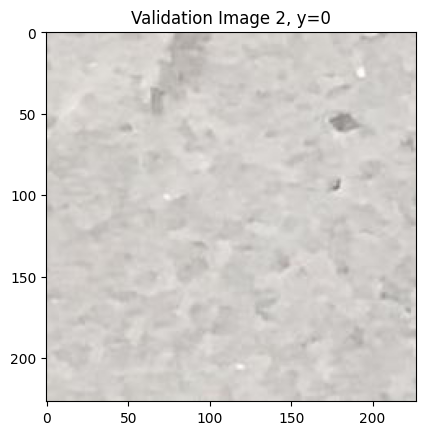

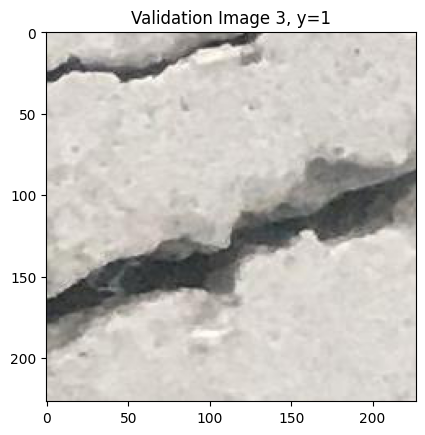

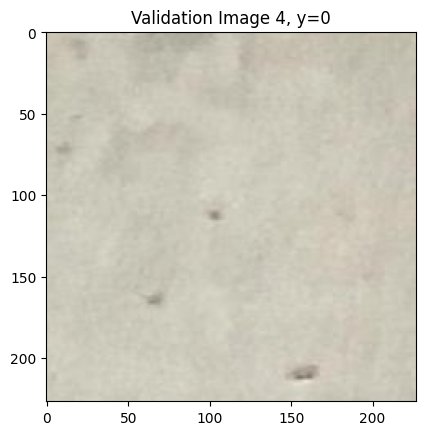

In [102]:

# Display the first four images from the validation dataset
print("Validation Dataset:")
for i in range(4):
    image, label = validation_dataset[i]
    plt.imshow(image)
    plt.title(f"Validation Image {i+1}, y={label.item()}")
    plt.show()

In [103]:
# Define the mean and standard deviation
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Create the transform object
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [104]:
dataset_train=Dataset(transform=transform,train=True)
dataset_val=Dataset(transform=transform,train=False)

In [105]:
dataset_train[0][0].shape

torch.Size([3, 227, 227])

In [106]:
size_of_image=3*227*227
size_of_image

154587

In [107]:


# Define the custom model
class Model(nn.Module):
    def __init__(self, input_size):
        super(Model, self).__init__()
        self.linear = nn.Linear(input_size, 2)  # Two classes

    def forward(self, x):
        return self.linear(x.view(x.size(0), -1))  # Flatten the input

# Set random seed for reproducibility
torch.manual_seed(0)

# Initialize the model
model = Model(size_of_image)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.1)

# Training parameters
batch_size = 5
epochs = 5

# Data loaders
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

# Training loop
max_accuracy = 0.0
for epoch in range(epochs):
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels.long()).sum().item()  # Ensure labels are of type LongTensor

    accuracy = correct / total
    max_accuracy = max(max_accuracy, accuracy)
    print(f"Epoch {epoch+1}/{epochs}, Accuracy: {accuracy:.2f}, Max Accuracy: {max_accuracy:.2f}")

print(f"Maximum Accuracy Achieved: {max_accuracy:.2f}")

Epoch 1/5, Accuracy: 0.83, Max Accuracy: 0.83
Epoch 2/5, Accuracy: 0.84, Max Accuracy: 0.84
Epoch 3/5, Accuracy: 0.50, Max Accuracy: 0.84
Epoch 4/5, Accuracy: 0.78, Max Accuracy: 0.84
Epoch 5/5, Accuracy: 0.85, Max Accuracy: 0.85
Maximum Accuracy Achieved: 0.85


In [ ]:
from torchvision.models import resnet18

# Load the pre-trained ResNet-18 model
model = resnet18(pretrained=True)

In [ ]:
# Disable gradient computation for all parameters
for param in model.parameters():
    param.requires_grad = False

In [ ]:
import torch.nn as nn
import torchvision.models as models

# Load a pre-trained model (e.g., ResNet18)
model = models.resnet18(pretrained=True)

# Replace the fully connected layer (model.fc) with a new layer for 2 classes
model.fc = nn.Linear(in_features=512, out_features=2)

# Print the modified model
print(model)

In [ ]:
import numpy as np

def cross_entropy_loss(y_true, y_pred):
    """
    Computes the cross-entropy loss between true labels and predicted probabilities.

    Parameters:
    y_true (numpy.ndarray): One-hot encoded true labels (shape: [n_samples, n_classes]).
    y_pred (numpy.ndarray): Predicted probabilities (shape: [n_samples, n_classes]).

    Returns:
    float: Cross-entropy loss.
    """
    # Clip predictions to avoid log(0)
    y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
    # Compute cross-entropy loss
    loss = -np.sum(y_true * np.log(y_pred)) / y_true.shape[0]
    return loss

SyntaxError: incomplete input (2091383719.py, line 2)

In [ ]:
from torch.utils.data import DataLoader, random_split

# Assuming `dataset` is your complete dataset object
# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoader objects for training and validation
batch_size = 100
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
import torch

# Assuming `model` is already defined and initialized
optimizer = torch.optim.Adam([parameters for parameters in model.parameters() if parameters.requires_grad], lr=0.001)

# Example of a training loop
for epoch in range(num_epochs):
    for inputs, targets in dataloader:  # Assuming `dataloader` is defined
        optimizer.zero_grad()  # Clear gradients
        outputs = model(inputs)  # Forward pass
        loss = loss_function(outputs, targets)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update parameters

In [ ]:
n_epochs=1
loss_list=[]
accuracy_list=[]
correct=0
N_test=len(validation_dataset)
N_train=len(train_dataset)
start_time = time.time()
#n_epochs

Loss=0
start_time = time.time()
for epoch in range(n_epochs):
    for x, y in train_loader:

        model.train() 
        #clear gradient 
     
        #make a prediction 
   
        # calculate loss 
    
        # calculate gradients of parameters 
        
        # update parameters 
        
        loss_list.append(loss.data)
    correct=0
    for x_test, y_test in validation_loader:
        # set model to eval 
       
        #make a prediction 
        
        #find max 
       
       
        #Calculate misclassified  samples in mini-batch 
        #hint +=(yhat==y_test).sum().item()
        
   
    accuracy=correct/N_test



In [ ]:
accuracy 
plt.plot(loss_list)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()


In [ ]:
# Assuming you have the following variables already defined:
# - `validation_data`: The input features of the validation dataset.
# - `validation_labels`: The true labels of the validation dataset.
# - `model`: The trained model used for predictions.

# Get predictions from the model
predictions = model.predict(validation_data)

# Convert predictions to class labels (if necessary)
predicted_labels = predictions.argmax(axis=1)  # For classification models with probabilities

# Identify misclassified samples
misclassified_indices = [i for i, (true, pred) in enumerate(zip(validation_labels, predicted_labels)) if true != pred]

# Get the first four misclassified samples
first_four_misclassified = misclassified_indices[:4]

# Print the results
print("Indices of the first four misclassified samples:", first_four_misclassified)
print("True labels of the misclassified samples:", [validation_labels[i] for i in first_four_misclassified])
print("Predicted labels of the misclassified samples:", [predicted_labels[i] for i in first_four_misclassified])